## ECDF as a differentiable mapping

In our pipeline, we would like to map some real valued
random variable $X\sim F$ to a uniform $U$ as
$$ U = F(X) $$
However, the usual way to perform this is to let
$$ \hat{F}_X^{(n)}(x) \triangleq \frac{1}{n+1}\sum_{i=1}^n\chi_{(0,\infty)}(x-x_i)$$

However if one needs to have the derivative $\nabla_x T(x)$ mapping $T\colon x\mapsto \hat{F}(x)$, this isn't practical.
Here we implement an alternative using sigmoids.

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Add directory above current directory to path
import sys; sys.path.insert(0, '../..'); sys.path.insert(0, '..')

from functions.miscellanea import _unpickle

In [1]:
# reference ECDF
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import ks_2samp as kst

In [49]:
def strange(n=1000, k=5):
    ''' k is the multiple of 3 from which to draw samples'''
    
    M = n//(3*k)
    mus = torch.distributions.Normal(loc=0,scale=5).rsample(sample_shape=(k,3))
    samples = []
    for m in mus: 
        a,b,c = torch.distributions.StudentT(df=5).rsample(sample_shape=(M,1)),\
                torch.distributions.Gamma(2,3).rsample(sample_shape=(M,1)),\
                torch.distributions.Normal(loc=1,scale=2.5).rsample(sample_shape=(M,1))
        
        samples.extend([a+m[0],b+m[1],c+m[0]])
    vals = torch.cat(samples,0)
    return vals

In [50]:
# generate some data:
N = 600
X = torch.distributions.StudentT(df=5).rsample(sample_shape=(N,1))
Y = strange(N)

In [212]:
# get theoretical distribution
def ecdf(vals, sort=True):
    idx = np.argsort(vals.ravel())
    v = vals[idx]
    ecdf = ECDF(v)
    cdvals = ecdf(v)
    if sort:
        return v,cdvals
    else:
        idx_inv = np.zeros(len(idx))
        for i in range(len(idx)):
            idx_inv[idx[i]] = i
        idx_inv = np.array(idx_inv).astype('int32')
        return v[idx_inv],cdvals.flatten()[idx_inv]

### Two examples
Using Scipy's ECDF as reference

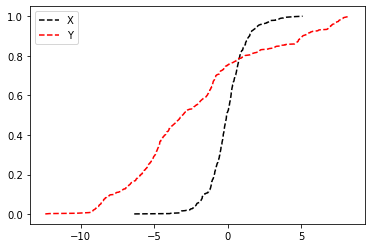

In [51]:
plt.plot(*ecdf(X.numpy()), 'k--' , label='X')
plt.plot(*ecdf(Y.numpy()), 'r--' , label='Y')
plt.legend()
plt.show()

In [52]:
ref_x, ref_x_ecdf = ecdf(X.numpy())
ref_y, ref_y_ecdf = ecdf(Y.numpy())

Get a barebone torch ecdf

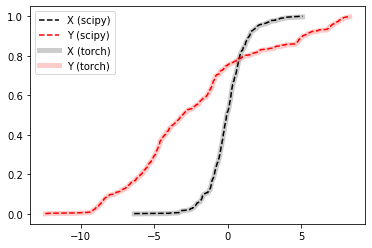

In [117]:
# first reimplement the cdf in torch:
def torch_ecdf(vals, compress=True):
    if vals.ndim > 1:
        if vals.shape[0]!=1 and vals.shape[1]!=1:
            raise ValueError("Only accepts 1d data",vals.shape)
        else:
            vals = vals.flatten()
            
    
    idx = torch.argsort(vals, dim=0)
    v = vals[idx]
    n = v.nelement()
    diffs = v.view(-1,1) - v.view(-1,1).t()
    # for an entry (i,j) gives X_i - X_j
    # we want to sum_j ind{X_j < X_i}
    diffs = ((diffs-1e-05).sign()+1)/2
    if compress:
        normalizer =  n+1
    else:
        normalizer = n
    cdvals = diffs.sum(dim=1) / normalizer
    return v.flatten(),cdvals.flatten()


plt.plot(*ecdf(X.numpy()), 'k--' , label='X (scipy)')
plt.plot(*ecdf(Y.numpy()), 'r--' , label='Y (scipy)')
plt.plot(*torch_ecdf(X), 'k' , label='X (torch)',
        lw=5, alpha=0.2)
plt.plot(*torch_ecdf(Y), 'r' , label='Y (torch)',
        lw=5, alpha=0.2)
plt.legend()
plt.show()

### Replace the step function by smooth sigmoid-based one
Using the approximation
$$ \mathbb{I}\{x>0\} \approx \sigma\left(\frac{x}{h}\right)$$

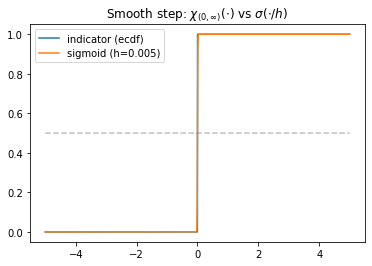

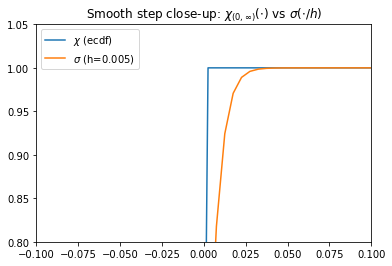

In [133]:
points = torch.linspace(-5,5,2000)
h = 5e-03
plt.plot(points, (points.sign()+1)/2, label='indicator (ecdf)')
plt.plot(points, (points/h).sigmoid(), label=f'sigmoid (h={h})')
plt.plot(points,torch.ones(points.nelement())/2,
         alpha=0.5, c='gray', linestyle='--')

plt.title(r"Smooth step: $\chi_{(0,\infty)}(\cdot)$ vs $\sigma(\cdot / h)$")
plt.legend()
plt.show()

# zoom in 

plt.plot(points, (points.sign()+1)/2, label=r'$\chi$ (ecdf)')
plt.plot(points, (points/h).sigmoid(), label=f'$\sigma$ (h={h})')
plt.plot(points,torch.ones(points.nelement())/2,
         alpha=0.5, c='gray', linestyle='--')
plt.xlim(-0.1,0.1)
plt.ylim(0.8,1.05)
plt.title(r"Smooth step close-up: $\chi_{(0,\infty)}(\cdot)$ vs $\sigma(\cdot / h)$")
plt.legend()
plt.show()

In [206]:
def torch_smooth_ecdf(vals, h=5e-03, compress=True, sort=True):
    if vals.ndim > 1:
        if vals.shape[0]!=1 and vals.shape[1]!=1:
            raise ValueError("Only accepts 1d data",vals.shape)
        else:
            vals = vals.flatten()
            
    
    idx = torch.argsort(vals, dim=0)
    v = vals[idx]
    n = v.nelement()
    diffs = v.view(-1,1) - v.view(-1,1).t()
    # for an entry (i,j) gives X_i - X_j
    # we want to sum_j ind{X_j < X_i}
    diffs = (diffs/h).sigmoid()
    if compress:
        normalizer =  n+1
    else:
        normalizer = n
    cdvals = diffs.sum(dim=1) / normalizer
    if sort:
        return v.flatten(),cdvals.flatten()
    else:
        idx_inv = torch.zeros(idx.nelement())
        for i in range(idx.nelement()):
            idx_inv[idx[i]] = i
        idx_inv = torch.Tensor(idx_inv).long()
        return v.flatten()[idx_inv],cdvals.flatten()[idx_inv]

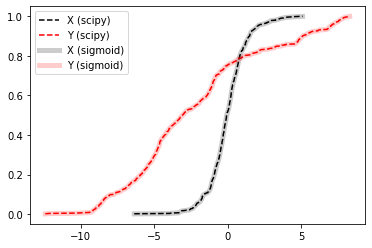

In [119]:
plt.plot(*ecdf(X.numpy()), 'k--' , label='X (scipy)')
plt.plot(*ecdf(Y.numpy()), 'r--' , label='Y (scipy)')
plt.plot(*torch_smooth_ecdf(X), 'k' , label='X (sigmoid)',
        lw=5, alpha=0.2)
plt.plot(*torch_smooth_ecdf(Y), 'r' , label='Y (sigmoid)',
        lw=5, alpha=0.2)
plt.legend()
plt.show()

### hard to see
Lets get the maximum difference

(tensor(0.0051), tensor(0.0033))


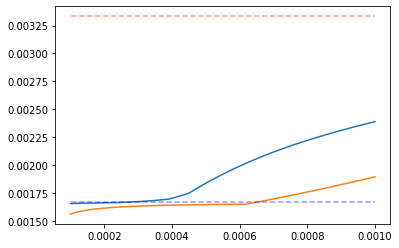

In [137]:
def _max_diff(X,h):
    return ((torch.Tensor(ecdf(X.numpy())[1]) - torch_smooth_ecdf(X,h=h,compress=False)[1]).abs().max(),
        (torch.Tensor(ecdf(X.numpy())[1]) - torch_ecdf(X,compress=False)[1]).abs().max())

print(_max_diff(X,h=0.01))

hvals = torch.linspace(1e-04,1e-03,100)
mdiffs_X = [_max_diff(X,h=h) for h in hvals]
mdiffs_Y = [_max_diff(Y,h=h) for h in hvals]

plt.plot( hvals, [mdx[0] for mdx in mdiffs_X])
plt.plot( hvals, [mdy[0] for mdy in mdiffs_Y])
plt.plot( hvals, [mdx[1] for mdx in mdiffs_X], 'r--', alpha=.4)
plt.plot( hvals, [mdy[1] for mdy in mdiffs_Y], 'b--', alpha=.4)
plt.show()

### A smooth Kolmogorov Smirnoff?
We need a softmax

In [160]:
vals = X.flatten()
print(((vals/5e-02).logsumexp(0))*5e-02, vals.max())
print(-((-vals/5e-02).logsumexp(0))*5e-02, vals.min())

tensor(5.1087) tensor(5.1087)
tensor(-6.3507) tensor(-6.3507)


**... To be continued !**

### Check on scatterplot
Visualize the smoothed empirical copula map
$$ (X,Y)\mapsto (\hat{F}_X(X), \hat{F}_Y(Y))$$

In [169]:
import seaborn as sns

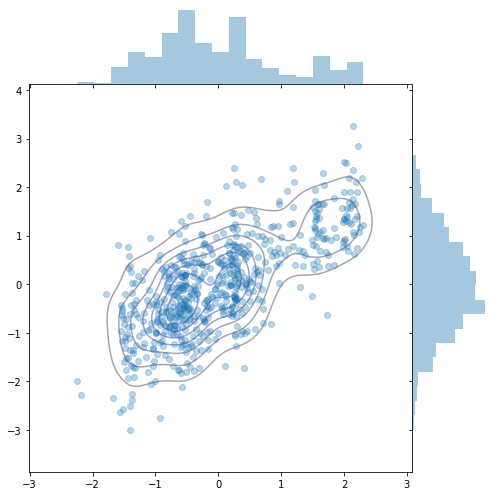

In [232]:
Y = (Y - Y.mean(0))/Y.std(0)
n1,n2 = torch.distributions.Normal(-0.2,1).rsample(sample_shape=(Y.nelement()//2,)),\
        torch.distributions.Normal(0.2,1).rsample(sample_shape=(Y.nelement()//2,))
n = torch.cat([n1,n2]) ; idx = torch.randperm(n.nelement()) ; n = n[idx]
YY = Y.flatten() + n ; YY = (YY- YY.mean(0))/YY.std(0)

sns.jointplot(Y.flatten(), YY,
              kind='scatter',
              ratio=5, height=7,
              space=0, alpha=0.3).plot_joint(sns.kdeplot,
                                             zorder=0,
                                             n_levels=8,
                                             alpha=0.4,
                                             color='blue')
plt.savefig('../data/copulas/empirical/original_joint',dpi=150)

plt.show()

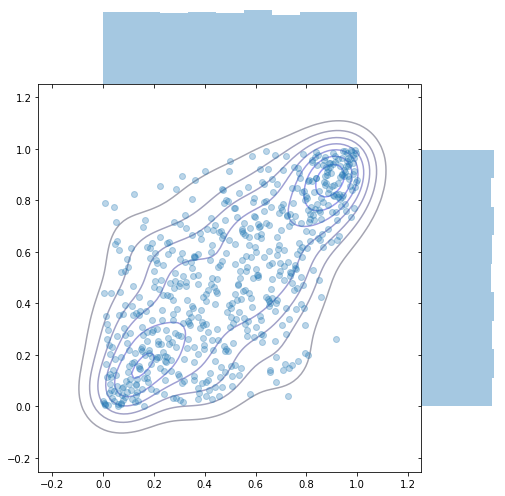

In [233]:
Y_u, YY_u = torch_smooth_ecdf(Y.flatten(), sort=False)[1],\
            torch_smooth_ecdf(YY.flatten(), sort=False)[1]

sns.jointplot(Y_u, YY_u,
              kind='scatter',
              ratio=5, height=7,
              space=0, alpha=0.3).plot_joint(sns.kdeplot,
                                             zorder=0,
                                             n_levels=8,
                                             alpha=0.4,
                                             color='blue')
plt.savefig('../data/copulas/empirical/smooth_ecop_joint',dpi=150)
plt.show()

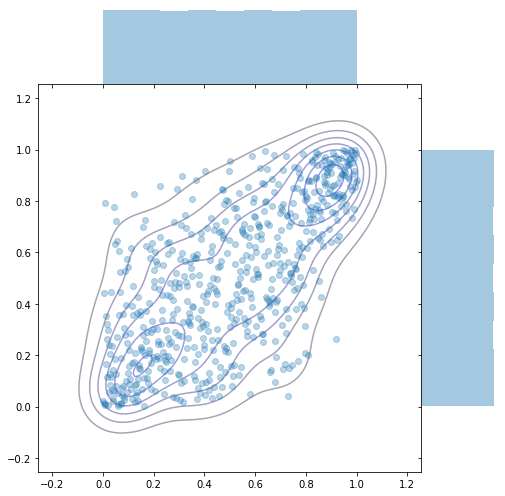

In [234]:
Y_u_e, YY_u_e = ecdf(Y.flatten().numpy(), sort=False)[1],\
            ecdf(YY.flatten().numpy(), sort=False)[1]

sns.jointplot(Y_u_e, YY_u_e,
              kind='scatter',
              ratio=5, height=7,
              space=0, alpha=0.3).plot_joint(sns.kdeplot,
                                             zorder=0,
                                             n_levels=8,
                                             alpha=0.4,
                                             color='blue')
plt.savefig('../data/copulas/empirical/discontinuous_ecop_joint',dpi=150)
plt.show()